# Anàlisi de Tècniques de Visualització - PAC 2

**Autor:** Arnau Toledano Rubí

**Assignatura:** M2.959 - Visualització de Dades

En aquest notebook, explorarem tres tècniques de visualització: Pie Chart, Stream Graph i Horizon Graph. Per a cadascuna, investigarem la seva definició, tipus de dades adients, i realitzarem una visualització pràctica amb dades obertes.

## 1. Gràfic Circular (Pie Chart)



### 1.1. Definició i Anàlisi
* **Nom:** Gràfic circular (Pie Chart).
* **Origen:** Atribuït a William Playfair (1801).
* **Funcionament:** Representa proporcions (part-a-tot) com a sectors d'un cercle. L'angle de cada sector és proporcional al valor que representa.
* **Aplicacions Típiques:** Quotes de mercat, composició d'un pressupost, resultats electorals, distribució demogràfica.
* **Avantatges:** Molt intuïtiu per entendre la composició d'un total (100%). Fàcil de llegir per a un públic no especialitzat.
* **Inconvenients:** Difícil de comparar sectors similars. Ineficaç amb més de 5-7 categories. La percepció es distorsiona fàcilment (p.ex., amb 3D).

### 1.2. Tipus i Estructura de Dades
* **Tipus:** 1 variable Categòrica (les "llesques") i 1 variable Quantitativa (la mida de la "llesca").
* **Estructura:** Dades que sumen un total significatiu. Per a aquest exercici, fem servir dades demogràfiques de l'Idescat.
* **Limitacions:** Funciona malament amb moltes categories.

### 1.3. Realització Pràctica (Python)

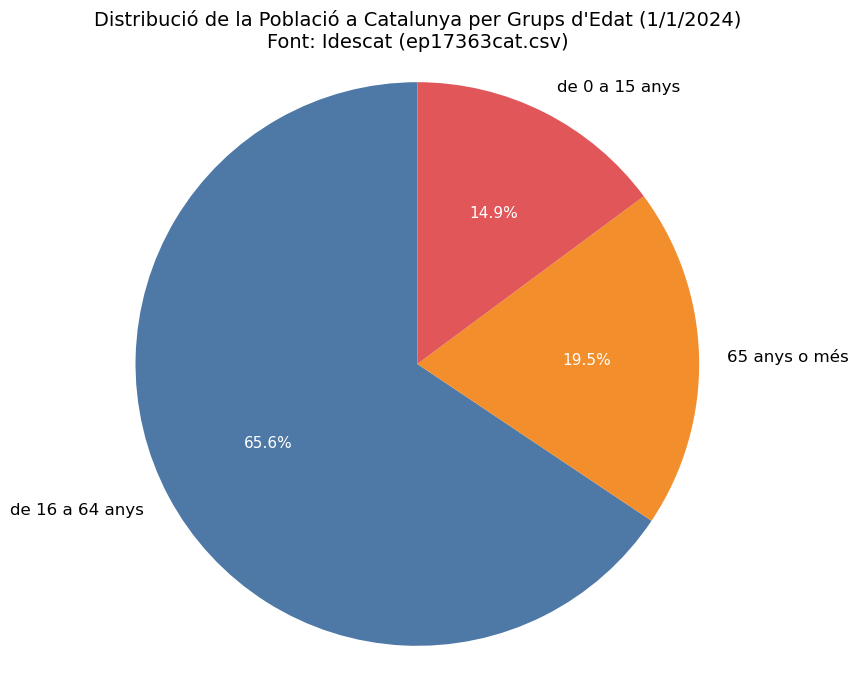

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Càrrega i Preparació de Dades ---
try:
    df = pd.read_csv('ep17363cat.csv')
except FileNotFoundError:
    df = pd.read_csv('data/ep17363cat.csv')

# Filtrem les dades per obtenir només el que necessitem:
# 1. Les dades més recents (S1/2024)
df_recent = df[df['semestre'] == 'S1/2024']

# 2. Només la població total (no 'homes' o 'dones')
df_total_sex = df_recent[df_recent['sexe'] == 'total']

# 3. Només els 3 grups d'edat que ens interessen (excloem la fila 'total' d'edat)
grups_edat = ['de 0 a 15 anys', 'de 16 a 64 anys', '65 anys o més']
df_final = df_total_sex[df_total_sex['edat'].isin(grups_edat)]

# Extreiem les dades per al gràfic
labels = df_final['edat']
sizes = df_final['valor']

# --- 2. Creació del Gràfic ---

# Reordenem per a millor visualització (opcional, però recomanat)
# Volem l'ordre: 16-64, 65+, 0-15
labels_ordenats = ['de 16 a 64 anys', '65 anys o més', 'de 0 a 15 anys']
sizes_ordenats = df_final.set_index('edat').loc[labels_ordenats]['valor']

# Destaquem la població activa
explode = (0.1, 0, 0)

fig, ax = plt.subplots(figsize=(8, 8))
patches, texts, autotexts = ax.pie(sizes_ordenats, labels=labels_ordenats, 
                                 autopct='%1.1f%%', # Mostra el percentatge
                                 shadow=False, startangle=90,
                                 colors=['#4E79A7', '#F28E2B', '#E15759'])

# Millorem la llegibilitat dels textos
for text in texts:
    text.set_fontsize(12)
for autotext in autotexts:
    autotext.set_fontsize(11)
    autotext.set_color('white')

ax.axis('equal')  # Assegura que sigui un cercle

plt.title("Distribució de la Població a Catalunya per Grups d'Edat (1/1/2024)\nFont: Idescat (ep17363cat.csv)", fontsize=14)
plt.savefig("img/pie_chart.png") # Desa la imatge pel README
plt.show()

---
---

## 2. Gràfic de Corrent (Stream Graph)



### 2.1. Definició i Anàlisi
* **Nom:** Gràfic de corrent (Stream Graph).
* **Origen:** Variant del gràfic d'àrees apilades. Popularitzat per Lee Byron i Martin Wattenberg (p.ex., "ThemeRiver").
* **Funcionament:** Mostra l'evolució de múltiples categories al llarg del temps (eix X). L'amplada de cada "corrent" (categoria) representa el seu volum. Es distribueix al voltant d'un eix central mòbil (baseline 'sym'), donant-li una forma orgànica.
* **Aplicacions Típiques:** Popularitat de gèneres musicals, mencions de temes a xarxes socials, evolució de la dieta d'un país, patrons climàtics estacionals.
* **Avantatges:** Visualment atractiu. Molt bo per veure tendències generals, proporcions canviants i patrons cíclics (estacionalitat).
* **Inconvenients:** Gairebé impossible llegir valors numèrics exactes. La dada crua pot generar molt "soroll", fent necessari un suavitzat.

### 2.2. Tipus i Estructura de Dades
* **Tipus:** 1 variable Contínua (Temps, eix X), 1 variable Categòrica (els "corrents") i 1 variable Quantitativa (l'amplada/volum).
* **Estructura:** Requereix dades "part-a-tot" al llarg del temps. En aquest cas, les dades originals (London Weather) no tenien aquesta estructura.
* **Transformació Aplicada:**
    1.  **Categorització:** Cada dia s'ha classificat en una de 4 categories ('Pluja', 'Sol', 'Ennuvolat', 'N/A').
    2.  **Agregació:** S'ha comptat el nombre de dies de cada categoria per a cada mes (1979-2020).
    3.  **Suavitzat:** Donat l'alt soroll de la variació mes a mes, s'ha aplicat una **mitjana mòbil (rolling average) de 12 mesos**. Això elimina els pics abruptes i revela les tendències estacionals subjacents, que és el nostre objectiu.

### 2.3. Realització Pràctica (Python)

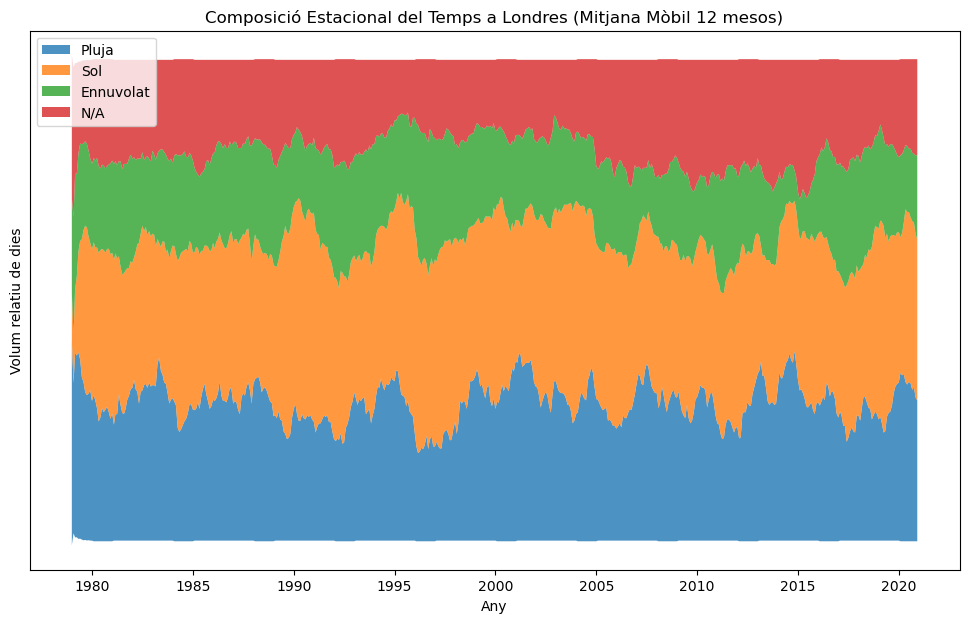

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Càrrega de Dades ---
try:
    # Intenta carregar des d'una possible carpeta 'data'
    df = pd.read_csv('data/london_weather.csv')
except FileNotFoundError:
    # Si falla, carrega des del directori principal
    df = pd.read_csv('london_weather.csv')

df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

# --- 2. Categorització (Transformació) ---
def categoritzar_dia(row):
    if row['precipitation'] > 1.0:
        return 'Pluja'
    if row['sunshine'] > 5.0:
        return 'Sol'
    if row['cloud_cover'] > 6:
        return 'Ennuvolat'
    return 'N/A' # Dies que no són ni molt plujosos, ni molt assolellats, ni molt ennuvolats

df['tipus_dia'] = df.apply(categoritzar_dia, axis=1)

# --- 3. Agrupació i Recompte ---
df['mes'] = df['date'].dt.to_period('M')
df_agrupat = df.groupby(['mes', 'tipus_dia']).size().reset_index(name='nombre_dies')

# --- 4. Pivotar les Dades ---
df_pivot = df_agrupat.pivot(index='mes', columns='tipus_dia', values='nombre_dies').fillna(0)

categories = ['Pluja', 'Sol', 'Ennuvolat', 'N/A']
for cat in categories:
    if cat not in df_pivot.columns:
        df_pivot[cat] = 0
df_pivot = df_pivot[categories] # Assegura l'ordre


# --- 5. SUAVITZAT DE DADES (AQUEST ÉS EL CANVI CLAU) ---
# Apliquem una mitjana mòbil (rolling average) per suavitzar el soroll.
# Una finestra de 12 mesos és ideal per a dades estacionals.
# .mean() calcula la mitjana d'aquesta finestra.
df_suavitzat = df_pivot.rolling(window=12, min_periods=1).mean()


# --- 6. Visualització (Amb dades suavitzades) ---
labels = df_suavitzat.columns
anys_mesos = df_suavitzat.index.to_timestamp() # Convertim Period a Timestamp

# Important: Ara fem servir 'df_suavitzat' per a les dades
dades_apilades = [df_suavitzat[cat] for cat in labels] 

fig, ax = plt.subplots(figsize=(12, 7))
ax.stackplot(anys_mesos, dades_apilades,
             labels=labels,
             baseline='sym', 
             alpha=0.8)

ax.legend(loc='upper left')
# Títol i eixos actualitzats per reflectir el canvi
plt.title("Composició Estacional del Temps a Londres (Mitjana Mòbil 12 mesos)")
plt.xlabel("Any")
plt.ylabel("Volum relatiu de dies")
plt.yticks([]) 
plt.savefig("img/stream_graph_suavitzat.png") # Guarda amb un nom nou
plt.show()

---
---

## 3. Gràfic d'Horitzó (Horizon Graph)



### 3.1. Definició i Anàlisi
* **Nom:** Gràfic d'horitzó (Horizon Graph).
* **Origen:** Desenvolupat a Bell Labs (S.G. Eick) i refinat per Panopticon.
* **Funcionament:** És una tècnica per a visualitzar **múltiples sèries temporals** en un espai molt compacte. "Plega" un gràfic d'àrea estàndard. Divideix la magnitud (eix Y) en bandes. Aquestes bandes es col·lapsen una sobre l'altra. Els valors positius i negatius s'utilitzen amb colors diferents (p.ex., blau i vermell), i la intensitat del color representa la magnitud (com més fosc, més lluny de zero).
* **Aplicacions Típiques:** Monitorització de servidors (CPU/memòria), *dashboards* financers (accions), dades climàtiques (temperatures).
* **Avantatges:** Densitat d'informació extremadament alta. Permet comparar patrons, tendències i anomalies entre moltes sèries a la vegada.
* **Inconvenients:** No és intuïtiu. Requereix explicació. Sacrifica la precisió numèrica per la visió de conjunt i el patró.

### 3.2. Tipus i Estructura de Dades
* **Tipus:** Múltiples sèries temporals. (Temps + ID de la sèrie + Valor quantitatiu).
* **Estructura:** Per a aquest exercici, fem servir el fitxer **`ep17363cat.csv`**. Aquest fitxer conté l'evolució de la població per grups d'edat des de 1981.
* **Transformació Clau:** Les escales de les 3 sèries temporals (grups d'edat) són diferents. Per poder comparar els seus patrons d'evolució, és imprescindible **normalitzar les dades (Z-score)**. Això posa totes les sèries en una escala comuna, centrada en la seva pròpia mitjana històrica.

### 3.3. Realització Pràctica (Python)

Error amb horizonplot: horizonplot() missing 2 required positional arguments: 'key' and 'width'

Provant amb la signatura alternativa...
Error amb segona prova: horizonplot() missing 2 required positional arguments: 'key' and 'width'

Creant horizon chart manual...


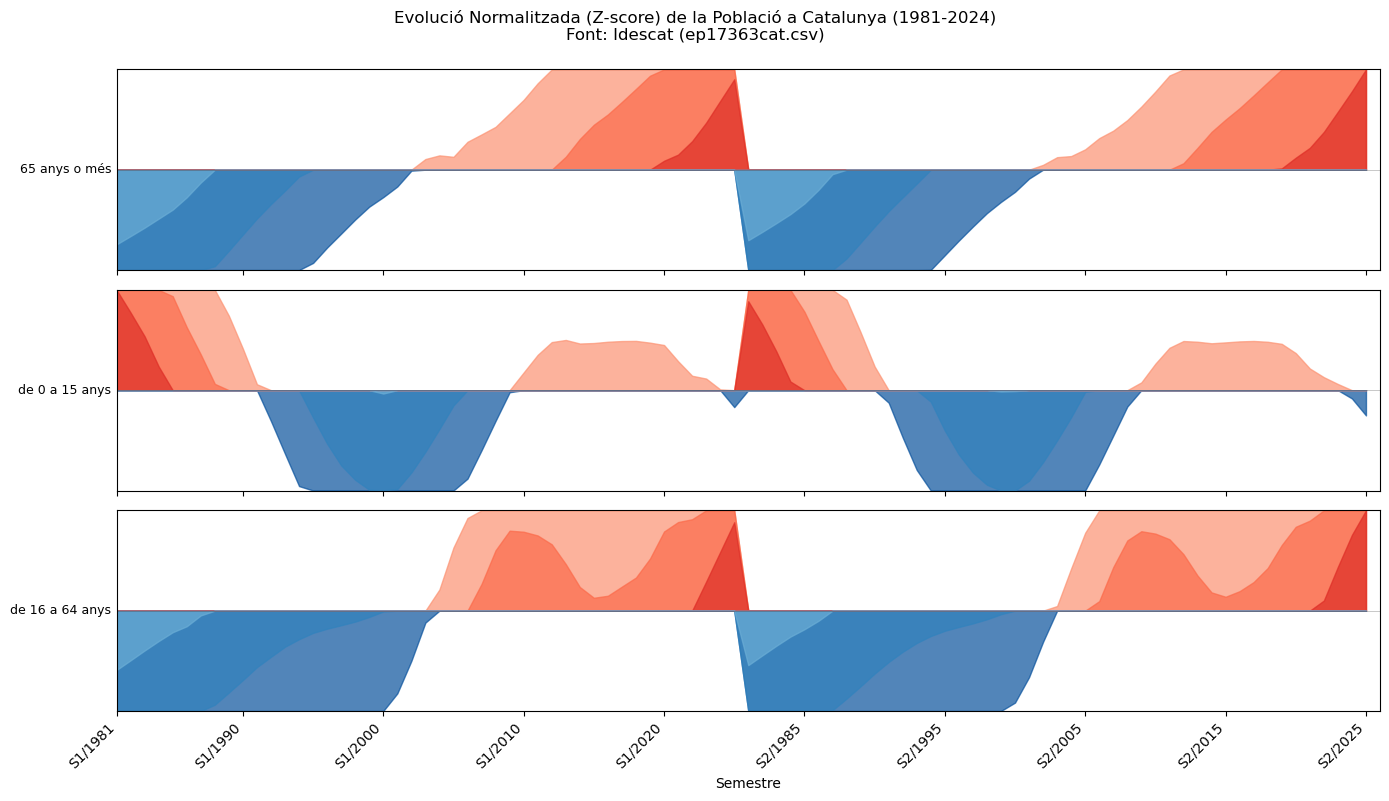

Gràfic creat amb èxit utilitzant implementació manual!


In [13]:
from horizonplot import horizonplot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Càrrega i Preparació de Dades ---
try:
    df_raw = pd.read_csv('ep17363cat.csv')
except FileNotFoundError:
    df_raw = pd.read_csv('data/ep17363cat.csv')

# Filtrem les dades per obtenir només el que necessitem:
# 1. Només la població total (no 'homes' o 'dones')
df_filtered = df_raw[df_raw['sexe'] == 'total']

# 2. Només els 3 grups d'edat que ens interessen (excloem la fila 'total' d'edat)
grups_edat = ['de 0 a 15 anys', 'de 16 a 64 anys', '65 anys o més']
df_filtered = df_filtered[df_filtered['edat'].isin(grups_edat)]

# 3. Pivotem les dades per tenir:
#    Index = Temps (semestre)
#    Columnes = Categories (grups d'edat)
#    Valors = Població
df_pivot = df_filtered.pivot(index='semestre', columns='edat', values='valor')

# --- 2. Normalització (PAS CRUCIAL) ---
# Calculem el Z-score per a CADA COLUMNA (cada grup d'edat)
# (valor - mitjana) / desviació estàndard
df_norm = (df_pivot - df_pivot.mean()) / df_pivot.std()
df_norm = df_norm.fillna(0) # Omplim NaNs si n'hi ha

# --- 3. Creació del Gràfic d'Horitzó ---
# La funció horizonplot simplement accepta el dataframe directament
# Prova 1: Cridar-la només amb el dataframe
try:
    fig = horizonplot(df_norm)
    fig.suptitle(
        "Evolució Normalitzada (Z-score) de la Població a Catalunya (1981-2024)\nFont: Idescat (ep17363cat.csv)",
        y=1.02
    )
    plt.tight_layout()
    plt.savefig("img/horizon_graph.png", dpi=300, bbox_inches='tight')
    plt.show()
except Exception as e:
    print(f"Error amb horizonplot: {e}")
    print("\nProvant amb la signatura alternativa...")
    
    # Prova 2: Si la anterior falla, intentem passar-li arrays directament
    try:
        # Resetegem l'index per tenir valors numèrics
        df_for_plot = df_norm.reset_index(drop=True)
        fig = horizonplot(df_for_plot)
        fig.suptitle(
            "Evolució Normalitzada (Z-score) de la Població a Catalunya (1981-2024)\nFont: Idescat (ep17363cat.csv)",
            y=1.02
        )
        plt.tight_layout()
        plt.savefig("img/horizon_graph.png", dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e2:
        print(f"Error amb segona prova: {e2}")
        print("\nCreant horizon chart manual...")
        
        # Prova 3: Implementació manual d'un horizon chart
        from matplotlib.colors import LinearSegmentedColormap
        
        fig, axes = plt.subplots(len(df_norm.columns), 1, figsize=(14, 8), sharex=True)
        
        # Colors per a les bandes (blau per negatiu, vermell per positiu)
        n_bands = 3
        
        for idx, col in enumerate(df_norm.columns):
            ax = axes[idx] if len(df_norm.columns) > 1 else axes
            data = df_norm[col].values
            
            # Creem les bandes de l'horizon chart
            data_max = np.abs(data).max()
            band_size = data_max / n_bands
            
            # Colors per cada banda
            colors_neg = ['#08519c', '#3182bd', '#6baed6']  # Blaus (més fosc = més negatiu)
            colors_pos = ['#fc9272', '#fb6a4a', '#de2d26']  # Vermells (més fosc = més positiu)
            
            # Dibuixem cada banda
            x = np.arange(len(data))
            
            for band in range(n_bands):
                # Banda positiva
                y_pos = np.clip(data - band * band_size, 0, band_size)
                ax.fill_between(x, 0, y_pos, color=colors_pos[band], alpha=0.7)
                
                # Banda negativa
                y_neg = np.clip(-data - band * band_size, 0, band_size)
                ax.fill_between(x, 0, -y_neg, color=colors_neg[band], alpha=0.7)
            
            # Configuració de l'eix
            ax.set_ylim(-band_size, band_size)
            ax.set_ylabel(col, rotation=0, ha='right', va='center', fontsize=9)
            ax.set_xlim(0, len(data))
            ax.axhline(0, color='black', linewidth=0.5, alpha=0.3)
            ax.set_yticks([])
            
            # Només mostrem les etiquetes de l'eix X a l'últim gràfic
            if idx < len(df_norm.columns) - 1:
                ax.set_xticklabels([])
        
        # Ajustem les etiquetes de l'eix X
        n_ticks = 10
        tick_positions = np.linspace(0, len(df_norm) - 1, n_ticks, dtype=int)
        axes[-1].set_xticks(tick_positions)
        axes[-1].set_xticklabels([df_norm.index[i] for i in tick_positions], rotation=45, ha='right')
        axes[-1].set_xlabel('Semestre')
        
        fig.suptitle(
            "Evolució Normalitzada (Z-score) de la Població a Catalunya (1981-2024)\nFont: Idescat (ep17363cat.csv)",
            y=0.995,
            fontsize=12
        )
        
        plt.tight_layout()
        plt.savefig("img/horizon_graph.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        print("Gràfic creat amb èxit utilitzant implementació manual!")